In this notebook, We will be investigating the missing data in the demographics dataset. To this end, we delve into the following topics:
* 1. Data and Data PreProcessing
* 2. Investigating Missing Values
**  2.1 - Visual interpretations to decide MCAR or MAR
**  2.2 - Chi-Square tests with assumptions to decide MCAR or MAR
* 3. Imputation based on findings


It can also be read from the following link
https://medium.com/@itk48/missing-data-imputation-with-chi-square-tests-mcar-mar-3278956387c8

### Types Of Missing Data
To handle missing data, it is important to classify the missing data into one of the three categories: MCAR, MAR, or MNAR.

* MCAR (Missing Completely At Random) refers to data that is missing purely by chance. This could happen due to reasons like forgetfulness, or random technical issues (e.g., a data collection device running out of battery, random internet disconnections, etc.). In other words, the probability of data being missing is equal for all cases and is unrelated to either observed or unobserved variables.

* MAR (Missing At Random) refers to missing data that is related to another observed variable in the dataset. For example, suppose the missing values in the Exercise Regularly column depend on the participants' age. Older participants might be more likely to skip answering the question about exercise. In this case, the likelihood of missing data depends on the observed variable age but is not directly related to the unobserved values in the Exercise Regularly column itself.
* MNAR (Missing Not At Random) refers to missing data where the missingness is directly related to the value of the variable itself. For example, if people are asked about their weight, those with higher weights might be more likely to skip answering the question. This missingness is not explained by any other variables in the dataset. In other words, the probability of missing data depends directly on the unobserved values themselves.
To understand the nature of missing values, visualizations and some tests such as Chi-square give insights. In this article, we investigated the missing data with missing data heatmaps, box plots, and count plots. After we got some insights, we conducted the Chi-square test of independence to understand if the variables were likely to be related or not. Before we conducted the Chi-square test, we investigated the assumptions of Chi-square and considered the degree of freedom for the reliability of the test holistically. After we discussed the drawbacks of using the Chi-square in our case, we imputed the missing values based on our findings.

Let's get started.

# 1. DATA AND DATA PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import chi2_contingency

In [105]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Powerwash Simulator Dataset/data/demographics.csv'
df = pd.read_csv(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To print information about the DataFrame including the datatypes and missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11080 entries, 0 to 11079
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             11080 non-null  object 
 1   responses       10042 non-null  float64
 2   logins          11080 non-null  int64  
 3   first_login     11080 non-null  object 
 4   last_login      8248 non-null   object 
 5   country         10670 non-null  object 
 6   age             10964 non-null  float64
 7   gender          11018 non-null  object 
 8   n_demographics  11080 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 779.2+ KB


pid indicates a unique identifier for each player, and responses indicate responses to 6 psychological survey questionnaires via in-game pop-ups, described in reference 2. Other column names are self-explanatory.
From the output, we can observe the missing values, 1,038 for responses, 2,832 for last_login, 410 for country, 116 for age, and 62 for gender.


To quickly test if your data frame object has the right type of data

In [ ]:
df.head()

,pid,responses,logins,first_login,last_login,country,age,gender,n_demographics
0,p1,77.0,24,2022-08-18 22:53:05,2023-01-31 23:16:34,USA,22.0,Male,1
1,p10,340.0,16,2023-02-18 03:02:03,2023-03-04 12:33:53,Czech Republic,28.0,Female,1
2,p100,1.0,1,2022-09-07 16:06:20,NaN,UK,20.0,Transgender,1
3,p1000,1.0,1,2022-08-23 14:43:12,NaN,USA,18.0,Female,1
4,p10000,7.0,2,2022-09-03 23:50:01,2022-09-16 23:31:56,USA,44.0,Female,1


### date objects

In [ ]:
df['first_login'] = pd.to_datetime(df['first_login'], errors='coerce')
df['last_login'] = pd.to_datetime(df['last_login'], errors='coerce')

Converting the first_login and last_login columns to datetime format is due to data consistency in the first place. Also, we need them as a datetime object to make calculations and extract more variables.

### gender

In [ ]:
print(df['gender'].value_counts())

gender
Male                                                 6086
Female                                               3190
Non-binary                                            862
Transgender                                           389
Prefer not to say                                     125
Other                                                  86
Non-binary,Transgender                                 40
Transgender,Female                                     36
Female,Transgender                                     27
Transgender,Male                                       24
Female,Non-binary                                      17
Non-binary,Female                                      13
Male,Transgender                                       12
Intersex                                               11
Non-binary,Male                                         9
Male,Non-binary                                         8
Transgender,Non-binary                                  8
Transge

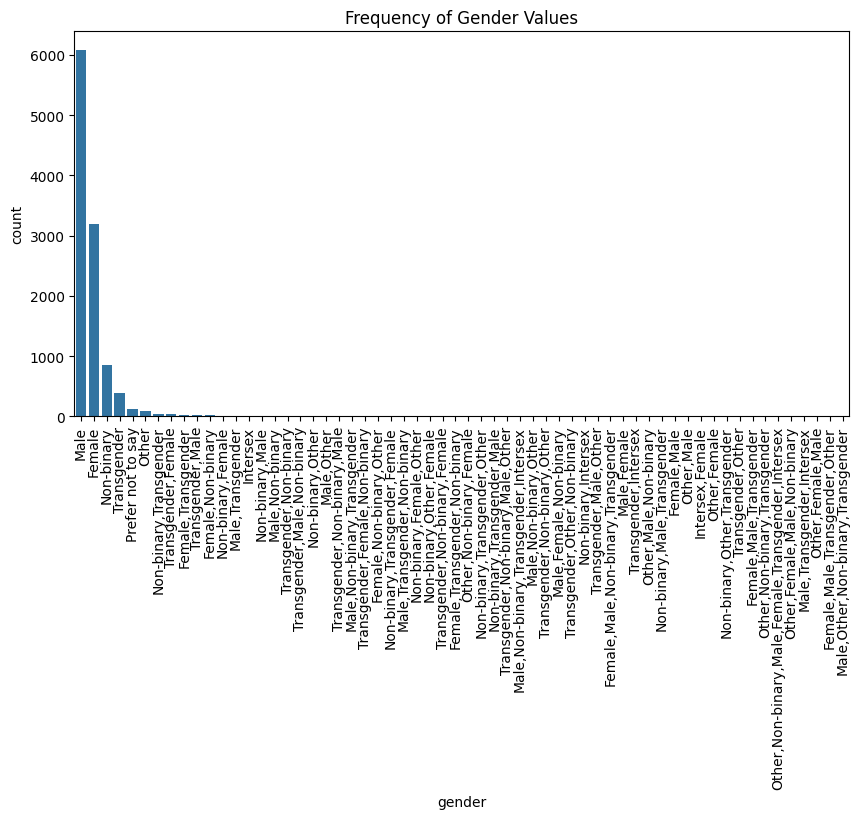

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='gender', order=df['gender'].value_counts().index)
plt.title("Frequency of Gender Values")
plt.xticks(rotation=90)
plt.show()

Too many identities clearly make the model more prone to overfitting. Therefore, we clean it to "Male", "Female" and "Other"


In [ ]:
def simplify_gender(gender):
    if pd.isna(gender):
        return gender  # Keep missing values as missing
    if 'Male' in gender and 'Female' not in gender:
        return 'Male'
    elif 'Female' in gender and 'Male' not in gender:
        return 'Female'
    else:
        return 'Other'

df['gender'] = df['gender'].apply(simplify_gender)

In [ ]:
print(df['gender'].value_counts())

gender
Male      6170
Female    3304
Other     1544
Name: count, dtype: int64


### Country

In [ ]:
print(df['country'].value_counts())

country
USA               5978
UK                1074
Canada             576
Germany            531
Australia          403
France             292
Netherlands        192
Japan              160
Sweden             125
South Korea        122
Denmark             91
Poland              81
Belgium             74
Brazil              73
Finland             72
Russia              69
New Zealand         64
China               59
Singapore           53
Norway              47
Ireland             44
Switzerland         44
Taiwan              43
Austria             43
Czech Republic      38
South Africa        35
Spain               32
Argentina           32
Philippines         30
Malaysia            29
Italy               25
Hungary             23
Romania             21
Portugal            18
Ukraine             18
Israel              17
Mexico              16
Iceland             13
Thailand            13
Name: count, dtype: int64


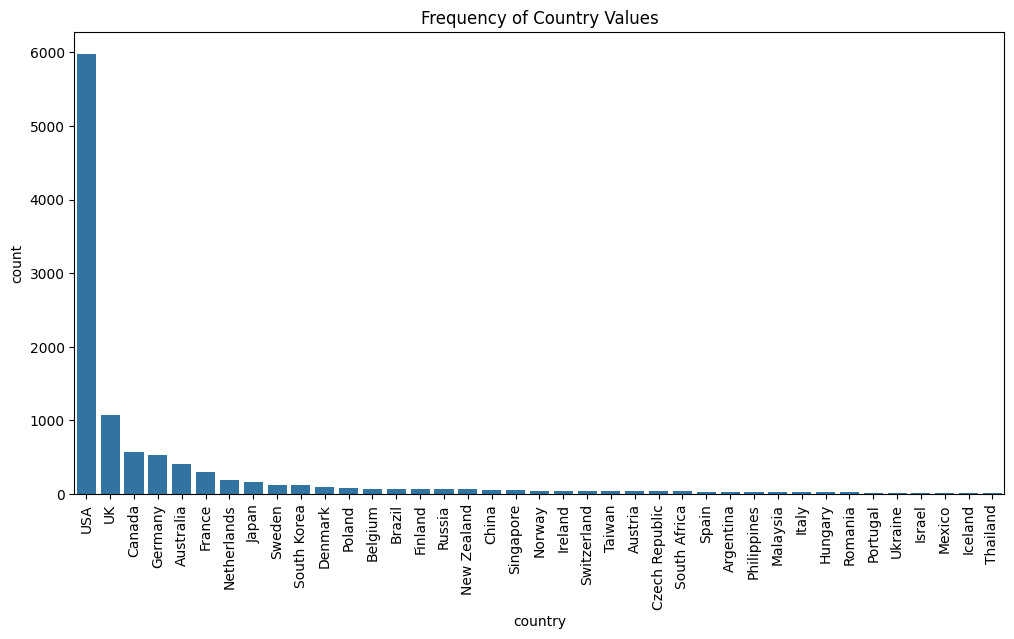

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='country', order=df['country'].value_counts().index)
plt.title("Frequency of Country Values")
plt.xticks(rotation=90)
plt.show()

Again, so many unique values in the country. We can quickly understand how to handle these identities by investigating the frequency distribution,

We should regroup the variables based on a threshold. One option should be regrouping the variables based on the percentage of the dataset which is more robust.

In [ ]:
threshold = int(0.01 * len(df))
country_counts = df['country'].value_counts(dropna=False)
df['country'] = df['country'].apply(lambda x: x if country_counts[x] >= threshold else 'Other')

There is a trade-off here. setting a threshold of %2 or maybe more leads to fewer unique values, a better training, but we lose some information. This information is important, especially in the context of retention analysis.


We can see the unique values and counts after processing,

In [ ]:
df['country'].value_counts()

,count
country,
USA,5978
Other,1217
UK,1074
Canada,576
Germany,531
Australia,403
France,292
Netherlands,192
Japan,160


### n_demographics

In [ ]:
print("Unique values in 'n_demographics':")
print(df['n_demographics'].unique())

Unique values in 'n_demographics':
[ 1  2  3  7  6  4 16]


In [ ]:
print("\nValue counts for 'n_demographics':")
print(df['n_demographics'].value_counts())


Value counts for 'n_demographics':
n_demographics
1     10833
2       232
3         8
7         3
4         2
6         1
16        1
Name: count, dtype: int64


While n_demographics has 7 unique values, it has only 1 value for "16", and almost % 97 of the data is "1". I believe we have nothing to do with this variable, so I extract this feature from the dataset.

In [ ]:
df.drop(columns=['n_demographics'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11080 entries, 0 to 11079
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pid          11080 non-null  object        
 1   responses    10042 non-null  float64       
 2   logins       11080 non-null  int64         
 3   first_login  11080 non-null  datetime64[ns]
 4   last_login   8248 non-null   datetime64[ns]
 5   country      10670 non-null  object        
 6   age          10964 non-null  float64       
 7   gender       11018 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 692.6+ KB


Data is ready now to investigate missing values

# 2. INVESTIGATING MISSING VALUES

The dataframe has missing values, 1,038 for responses, 2,832 for last_login, 410 for country, 116 for age, and 62 for gender.

### Last Login

Let's first understand the root cause of missingness here. The last_login is the most relevant with a number of logins. As there are no missing logins, check how many missing in last_login has only logged in once.

In [ ]:
missing_last_login_count = df[(df['logins'] == 1) & (df['last_login'].isna())].shape[0]
missing_last_login_count

2832

So all the missing values have been logged only once. Let's check if are there any players that logged in once but last_login is not missing

In [ ]:
non_missing_last_login_with_login_1 = df[(df['logins'] == 1) & (~df['last_login'].isna())]

non_missing_count = non_missing_last_login_with_login_1.shape[0]
non_missing_count

0

This means missing all of the last_login values is caused by a programming choice: the developer assigns the next login as the last_login, therefore if the player logs in only once, the last_login value goes missing. Let's handle this

In [ ]:
def impute_last_login(row):
    if pd.isna(row['last_login']) and row['logins'] == 1:
        return row['first_login']
    return row['last_login']


df['last_login'] = df.apply(impute_last_login, axis=1)

Given that the missingness in last_login is fully explained by the observed variable logins, we can confidently say that the missing data is MAR.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11080 entries, 0 to 11079
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pid          11080 non-null  object        
 1   responses    10042 non-null  float64       
 2   logins       11080 non-null  int64         
 3   first_login  11080 non-null  datetime64[ns]
 4   last_login   11080 non-null  datetime64[ns]
 5   country      10670 non-null  object        
 6   age          10964 non-null  float64       
 7   gender       11018 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 692.6+ KB


The remaining missing values are not straightforward. We need to do some investigation to understand if the missing values are MCAR or MAR so that we can decide on a filling strategy.
* 2.1 Visual Inspection: We start by looking at the pattern of missing values. If there is no apparent structure to the missing data, in other words, they are spread randomly across rows and columns without any relationship to other variables, they will conclude that they are likely MCAR. But if we are able to observe some patterns, we will conclude that they are MAR.
* 2.2 Missing Data Tests: To understand the independence of variables with missing data, we will be conducting the Chi-square test of independence. Before we conduct tests, we will also investigate if the assumptions for these tests are met.

## 2.1 - Visual Inspection to Decide MCAR or MAR

### Missing Data Heatmap

Missing data heatmaps visually depict the pattern and distribution of missing values in a dataset. They offer a quick overview of which columns contain missing data, the extent of that missingness, and whether any patterns or dependencies exist across different variables. In simple words, We investigate if the missing data is random or forms clusters, column by column, row by row.



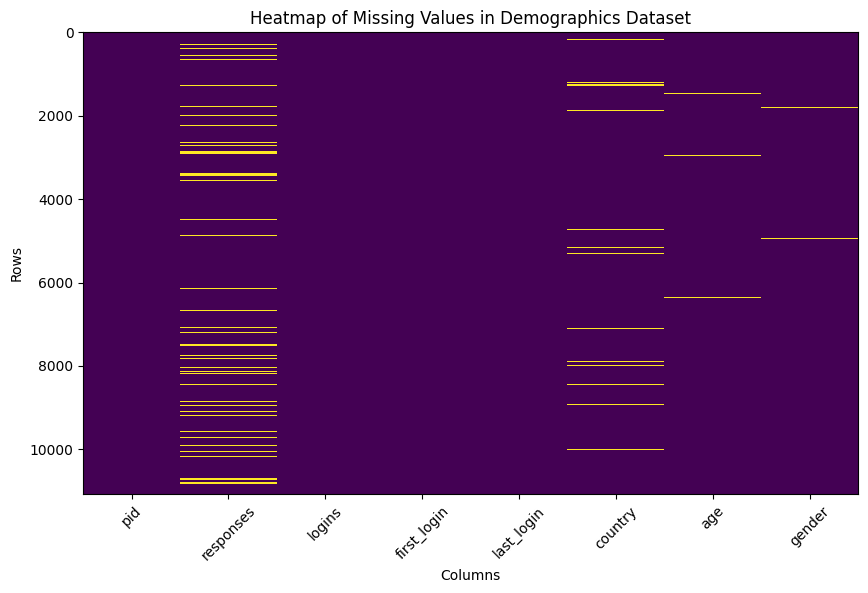

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(df.isnull(), aspect='auto', cmap='viridis', interpolation='nearest')
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.xticks(ticks=range(len(df.columns)), labels=df.columns, rotation=45)
plt.title("Heatmap of Missing Values in Demographics Dataset")
plt.show()

Clearly, responses have more frequent missing values compared to other variables. The missing values are not uniformly distributed but tend to cluster within certain rows.
The country also has visible missing values in the heatmap. The missing values appear across different rows, but there are some clusters where multiple consecutive rows have missing values. This clustered pattern suggests that the missingness is not completely random but might be influenced by other variables.
The few missing values for age and gender are spread across several rows and appear to follow some clustering patterns. This clustering suggests that certain groups of participants are more likely to have missing age and gender values, which implies a relationship with other features.
As we couldn't get a definitive conclusion, we had some insights and will be considering the heatmap with later findings.


### Pair Plot

Pair plot is important to see the relationship among the variables. This gives insighst not only to determine if missing values are MAR or MCAR, but also understand the features to predicts other variables.

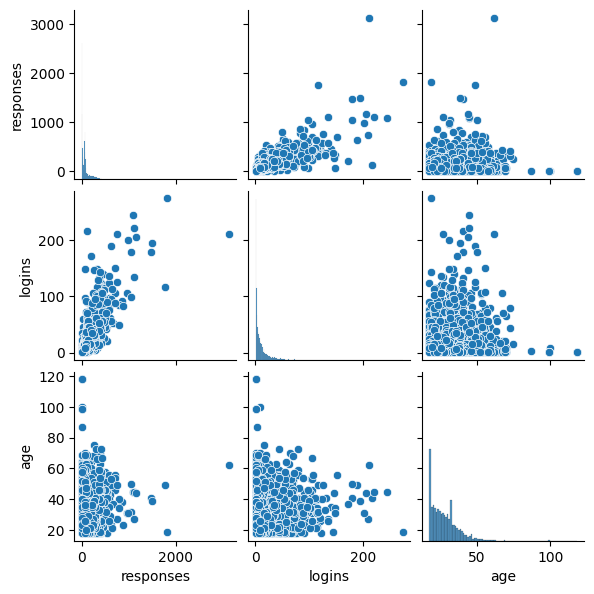

In [106]:
df_for_plot = df[['responses', 'logins', 'age',]]

sns.pairplot(df_for_plot, height=2)
plt.show()


**Pairwise Relationships:**

1. **Responses vs. Logins**:
   There is a positive correlation between **responses** and **logins**, evident from the upward trend in the scatter plot. This suggests that users with more logins tend to give more responses. The distribution of **responses** is highly right-skewed, with most users providing very few responses, while a small group contributes an exceptionally high number.

2. **Responses vs. Age**:
   There seem be to a negative correlation between **responses** and **age**, but need further confirmation.
  

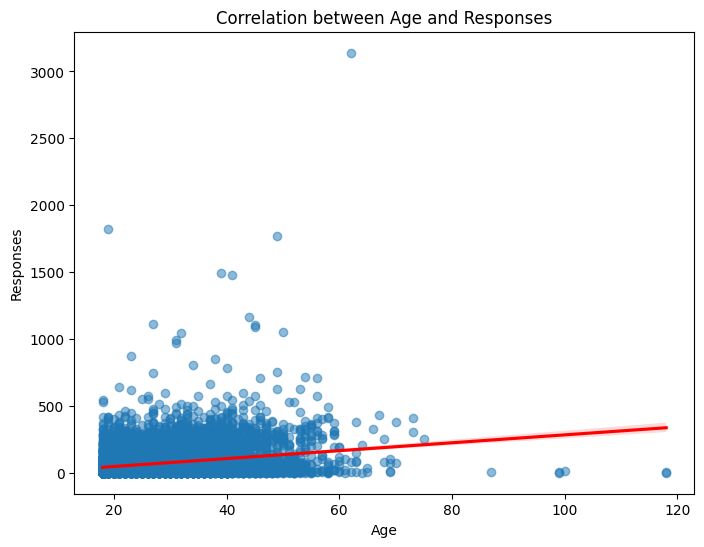

Correlation coefficient between 'age' and 'responses': 0.2484


In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='age', y='responses', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Correlation between Age and Responses')
plt.xlabel('Age')
plt.ylabel('Responses')
plt.show()

correlation_coefficient = df['age'].corr(df['responses'])
print(f"Correlation coefficient between 'age' and 'responses': {correlation_coefficient:.4f}")


The correlation coefficient between age and responses is 0.2484, which indicates a positive, weak correlation between the two variables.

3. **Logins vs. Age**: There seem be to a negative correlation between **logins** and **age**, but need further confirmation.
Lets further examine

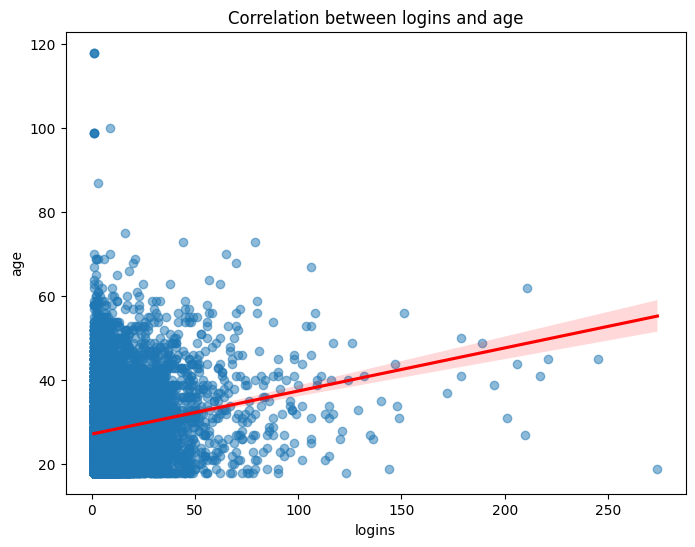

Correlation coefficient between 'logins' and 'age': 0.1864


In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='logins', y='age', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Correlation between logins and age')
plt.xlabel('logins')
plt.ylabel('age')
plt.show()

correlation_coefficient = df['logins'].corr(df['age'])
print(f"Correlation coefficient between 'logins' and 'age': {correlation_coefficient:.4f}")


- Based on the **pairplot**, it appears that `responses`, `age`, and `logins` are interrelated. The missingness in `responses` may depend on user age or activity levels (by login).

- `age` could potentially be **MCAR** if the missingness doesn’t have a significant relationship with other variables. However, in this dataset, it seems that `age` is related to both `responses` and `logins`, suggesting that its missingness might also be influenced by these behaviors.

- These findings are definitely useful to understand if the values are MCAR or MAR. Also will be used to select the variables to train machine learning models to predict missing values.



we create a binary missingness indicator for each variable to investigate the missingness of variables to other variables.

In [ ]:
df['is_missing_responses'] = df['responses'].isna()
df['is_missing_country'] = df['country'].isna()
df['is_missing_age'] = df['age'].isna()
df['is_missing_gender'] = df['gender'].isna()

### missing responses

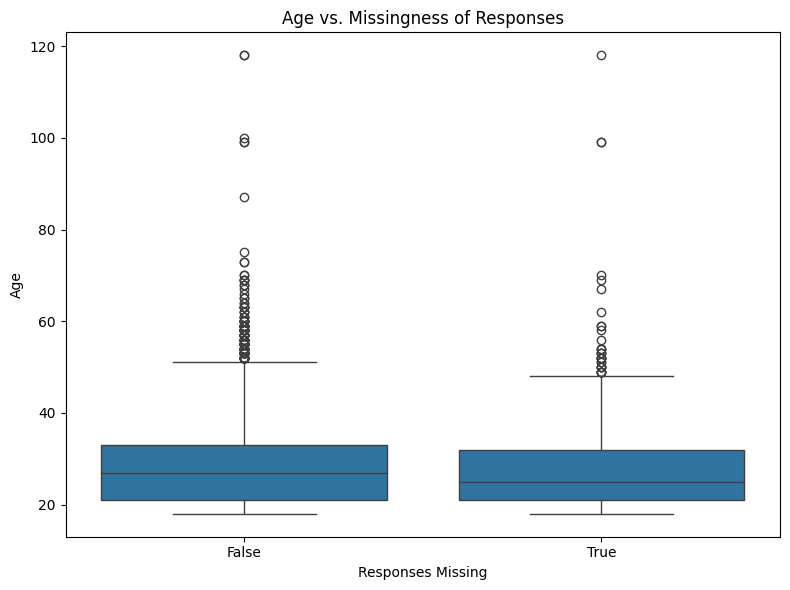

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_missing_responses', y='age')
plt.title('Age vs. Missingness of Responses')
plt.xlabel('Responses Missing')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

It appears that missing responses are more common among the younger participants, as the median age for users with missing responses seems lower. This implies the missingness of response seems related to age.


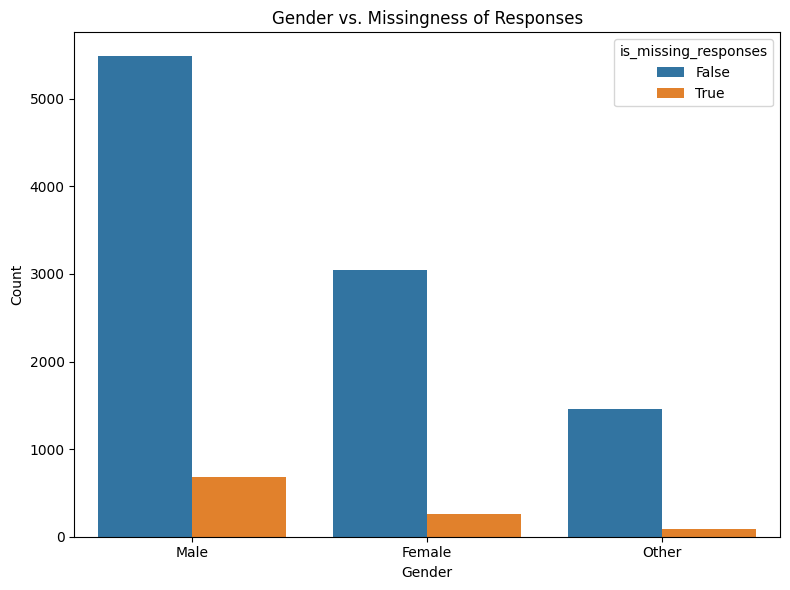

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='gender', hue='is_missing_responses')
plt.title('Gender vs. Missingness of Responses')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

There are a large number of 'Male' responses, with missing responses being a small proportion compared to non-missing responses. The same pattern is seen for 'Female' and 'Other'. The missingness of responses seems not to vary significantly by gender. This suggests that gender doesn't actually seem to have any influence on the missingness of responses.

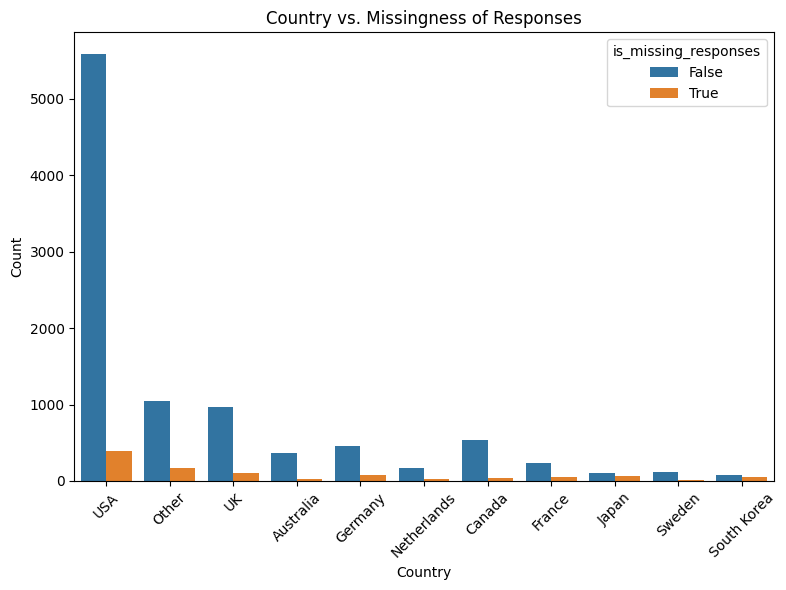

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='country', hue='is_missing_responses')
plt.title('Country vs. Missingness of Responses')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The missingness of responses does not seem to be strongly dependent on country. The relative proportions of missing vs. non-missing responses appear to be somewhat consistent across most countries, except for slight variations. It is difficult to imply if the missingness of responses is related to country.

### missing country

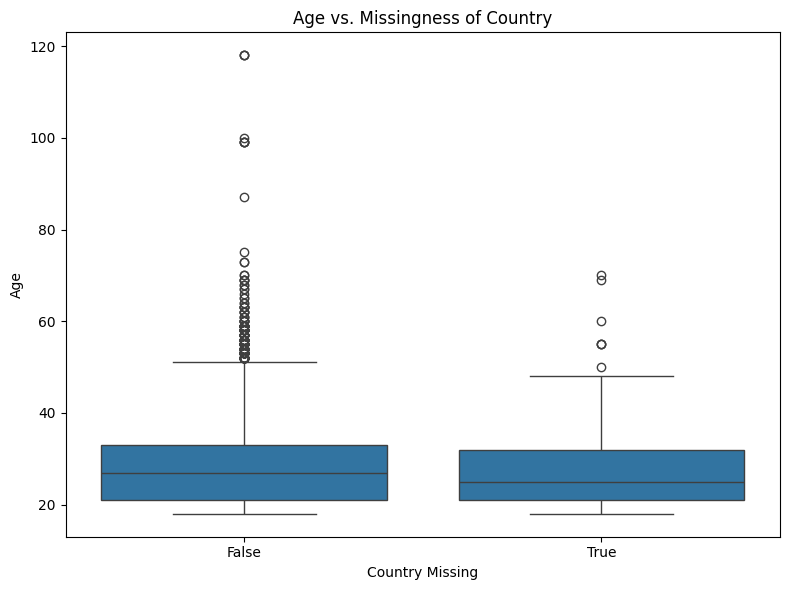

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_missing_country', y='age')
plt.title('Age vs. Missingness of Country')
plt.xlabel('Country Missing')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

It appears that younger users tend to have more missing country data compared to older users. The median age is lower for those with missing country information. This suggests that missingness in the country feature may be influenced by user age, which indicates that it should not be random.

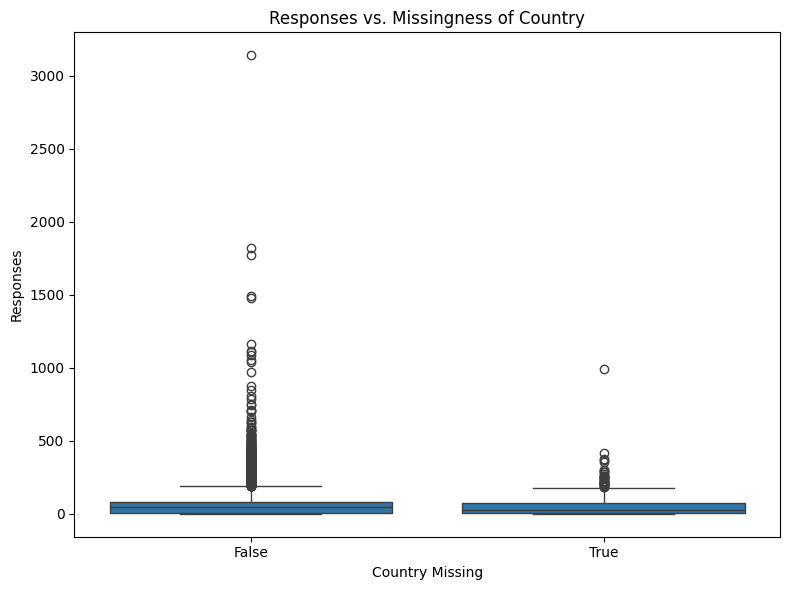

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_missing_country', y='responses')
plt.title('Responses vs. Missingness of Country')
plt.xlabel('Country Missing')
plt.ylabel('Responses')

plt.tight_layout()
plt.show()

Users with missing country information tend to have fewer responses compared to those with the country specified. This suggests that less engaged users may not provide country information. This relationship implies that the likelihood of missing country information may be influenced by user engagement.

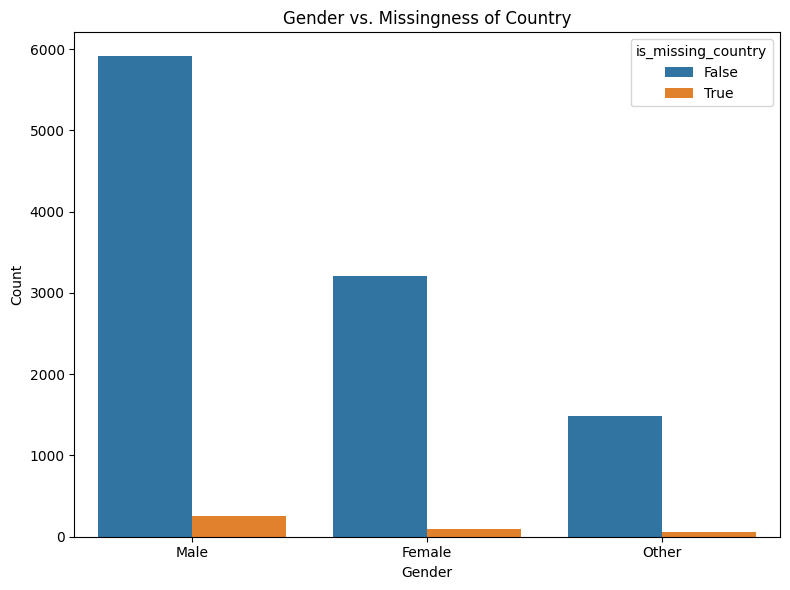

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='gender', hue='is_missing_country')
plt.title('Gender vs. Missingness of Country')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

For each gender category (Male, Female, Other), the proportion of missing vs. non-missing country data is quite similar. Males make up the largest group, followed by females and "Other." The proportion of missing country values is relatively consistent across all genders, with no group showing a significantly higher or lower rate of missing values.
Since the missingness of country is relatively consistent across different genders, it suggests that gender is not a determining factor for whether country information is missing. This consistency implies that the missing values for the country are MCAR with respect to gender.

### missing age

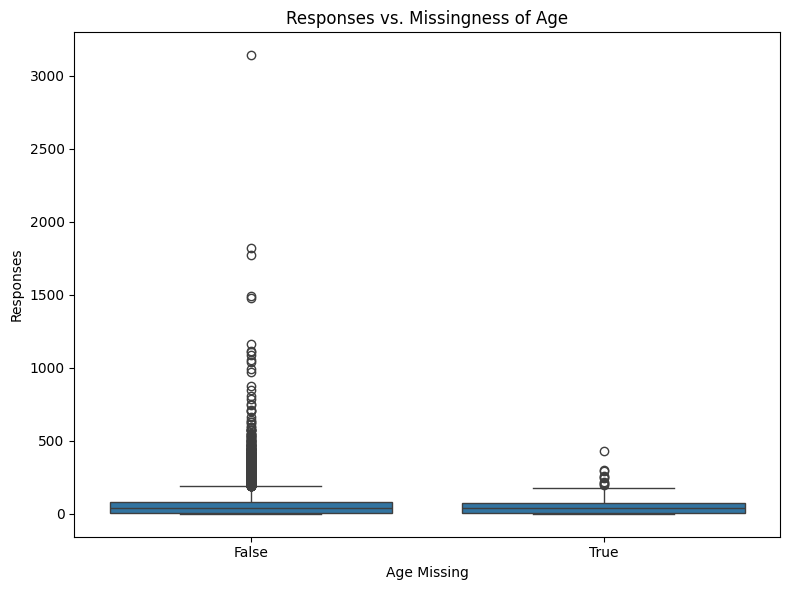

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_missing_age', y='responses')
plt.title('Responses vs. Missingness of Age')
plt.xlabel('Age Missing')
plt.ylabel('Responses')

plt.tight_layout()
plt.show()

The median response values for both groups seem very close, suggesting there may not be a substantial difference in central tendency. The group with false (age not missing) shows a higher spread and variance in the responses, including many outliers that go significantly higher than those in the true group. The interquartile ranges (IQRs) for both groups overlap, indicating potential similarity in the middle 50% of the data. In these circumstances, we couldn't observe a relationship between responses and missing age values.

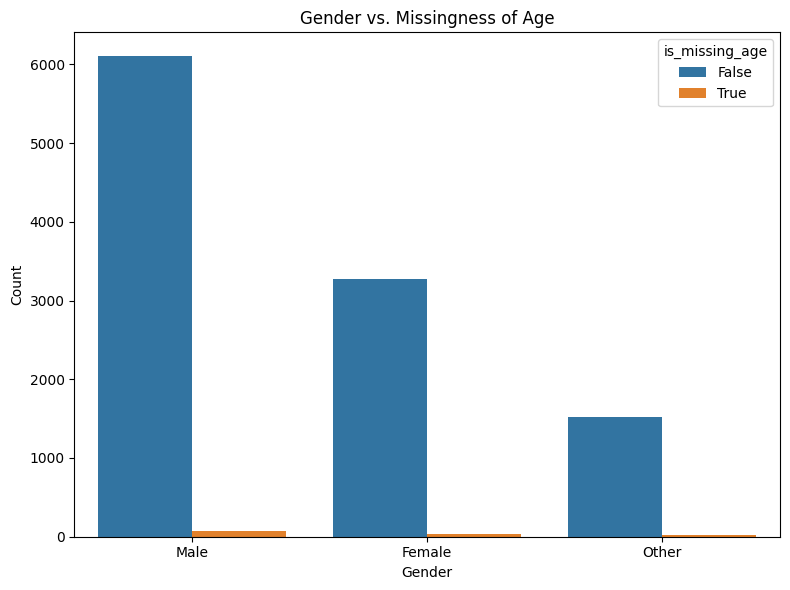

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='gender', hue='is_missing_age')
plt.title('Gender vs. Missingness of Age')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The missing age values (True) are a very small proportion compared to the non-missing values (False) across all gender categories. For males, females, and "Other" genders, the number of missing age values is very low, suggesting that gender is not strongly correlated with the missingness of age. The proportions of missing and non-missing values are consistent across the gender categories, indicating a similar pattern regardless of gender. It suggests that gender is not a determining factor for whether the age information is missing.

### missing gender

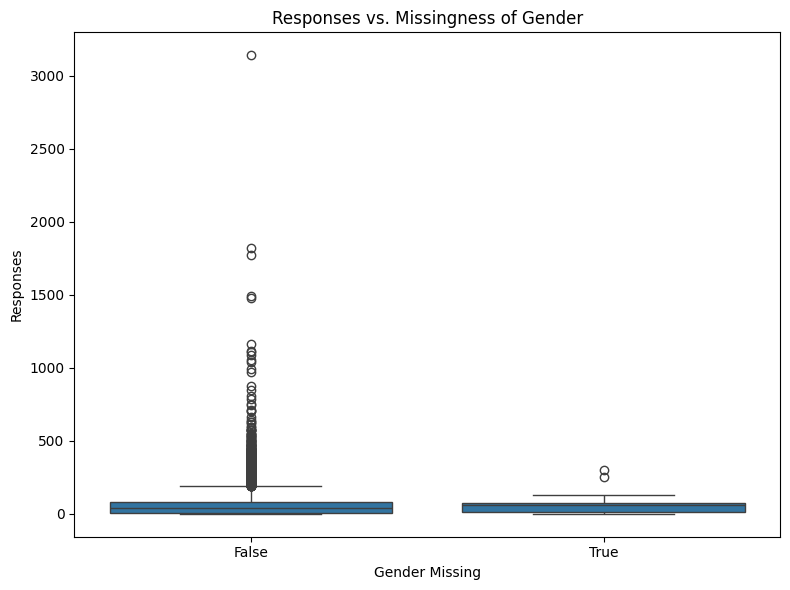

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_missing_gender', y='responses')
plt.title('Responses vs. Missingness of Gender')
plt.xlabel('Gender Missing')
plt.ylabel('Responses')

plt.tight_layout()
plt.show()

Users with missing gender information tend to have fewer responses compared to users with gender information available. This indicates that the missingness of gender data might be linked to user engagement. Specifically, less engaged users(in terms of responses) appear to be more likely to omit their gender, suggesting a relationship between activity level and missingness of the gender feature.

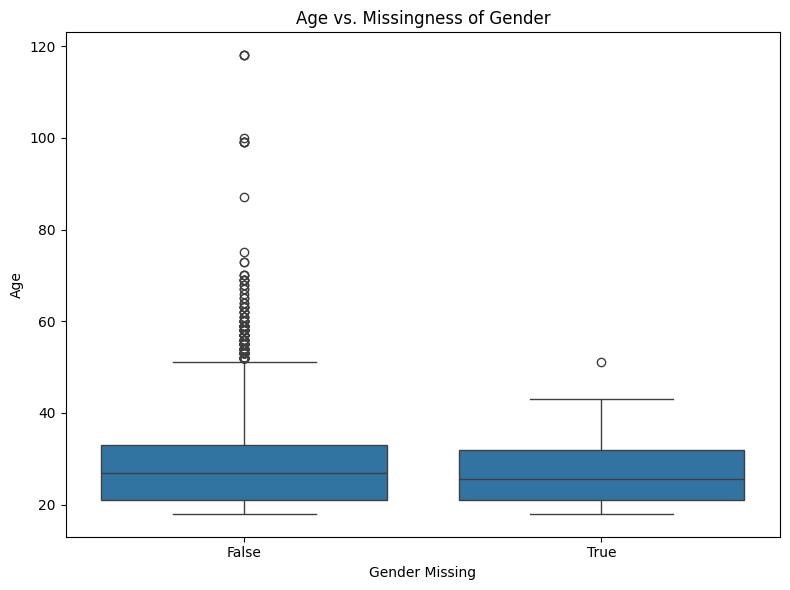

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='is_missing_gender', y='age')
plt.title('Age vs. Missingness of Gender')
plt.xlabel('Gender Missing')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

The boxplot for age vs. missing gender data reveals that users with missing gender information are often younger compared to those with the gender specified. This may suggest that the likelihood of missing gender information is related to age, with younger users being more likely to leave this field empty.

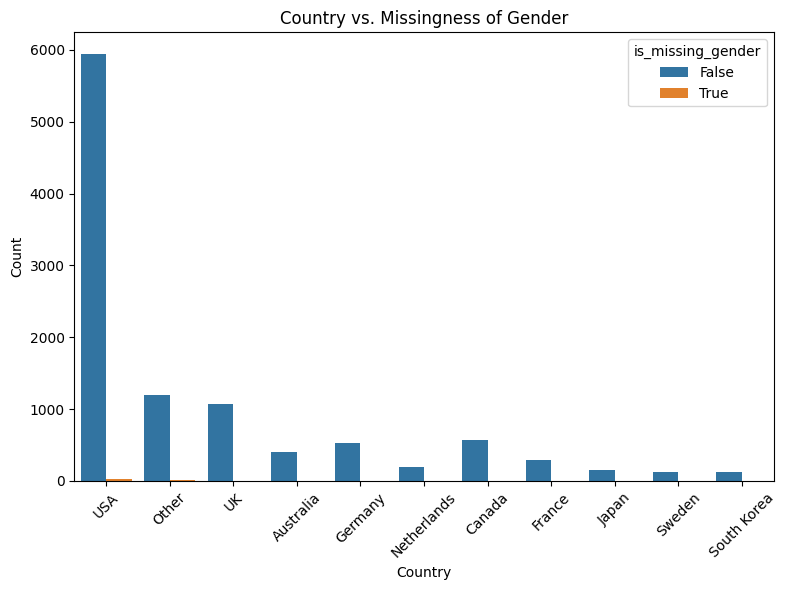

In [ ]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='country', hue='is_missing_gender')
plt.title('Country vs. Missingness of Gender')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The proportion of missing and non-missing values is relatively consistent across all countries. The USA, which has the most records, shows a very small proportion of missing values for gender, similar to other countries. The 'Other' category, which includes less frequent countries, also shows a similar ratio of missing and non-missing values. However since there are many categories in country, and there do not exist too many missing values in gender, it is difficult to observe a pattern from this plot.

##  2.2 Statistical Tests

Since the Chi-square test of independence is commonly used whether two variables are likely to be related or not, it is also commonly used to understand the nature of missing values. We will be conducting a Chi-square test on the variables: responses, country, age, and gender respectively. We will be investigating assumptions of Chi-square, and consider the degree of freedom for reliability of the test wholistically. At the end of the section, we will also discuss the drawbacks of using the Chi-square.

### Responses

In this section, we will be trying to investigate if missing responses are likely related to other variables in the dataset. The first assumption of the Chi-square test is that the variables must be categorical.
To apply the chi-square test, first, we need to create a new categorical variable using responses.

Data Preparation

In [ ]:
df['responses_category'] = pd.qcut(df['responses'], q=4, labels=['low', 'medium-low', 'medium-high', 'high'], duplicates='drop')
df['age_category'] = pd.qcut(df['age'], q=4, labels=['young', 'young-adult', 'middle-aged', 'old'], duplicates='drop')


As this approach creates ordinal categorical variables, the chi-square test treats as a nominal categorical variable. We will discuss this in the drawbacks section.

We create a missingness indicator to separate missing values from the rest.

In [ ]:
df['is_missing_responses'] = df['responses'].isna().astype(int)

To compare missing responses from other variables, we need to get rid of the missing values and compare them with the rest. For each variable, we create a new dataset to lose as little information as possible.

In [ ]:
df_non_missing_gender = df.dropna(subset=['gender'])
df_non_missing_country = df.dropna(subset=['country'])
df_non_missing_responses = df.dropna(subset=['responses_category'])
df_non_missing_age = df.dropna(subset=['age_category'])

To keep it clean, we reuse the following methods

In [ ]:
def perform_chi_square_test(df, missing_col, category_col):
    contingency_table = pd.crosstab(df[missing_col], df[category_col])
    chi2, p, degfre, expected = chi2_contingency(contingency_table)
    return chi2, p, degfre, expected


def interpret_p_value(p_value, category, compareWith):
    if p_value < 0.05:
        print(f"The missingness of {compareWith} is significantly related to {category}, indicating MAR.")
    else:
        print(f"The missingness of {compareWith} is not significantly related to {category}, indicating MCAR.")

In [ ]:
chi2_responses_gender, p_responses_gender, degfre_responses_gender, expected_responses_gender = perform_chi_square_test(df_non_missing_gender, 'is_missing_responses', 'gender')
chi2_responses_country, p_responses_country, degfre_responses_country, expected_responses_country = perform_chi_square_test(df_non_missing_country, 'is_missing_responses', 'country')
chi2_responses_age_cat, p_responses_age_cat, degfre_responses_age_cat, expected_responses_age_cat = perform_chi_square_test(df_non_missing_age, 'is_missing_responses', 'age_category')

For all the remaining tests, we assume that the assumptions of independent observations are met since the presence or absence of data in one observation should not influence another. The assumption of a large sample size is satisfied with an 11000+ sample size, and a large contingency table. What is left is that each expected frequency to be not less than 5.

In [ ]:
responses_expected_values = {
    'gender': expected_responses_gender,
    'country': expected_responses_country,
    'age_category': expected_responses_age_cat,
}

responses_degfre_values = {
    'gender': degfre_responses_gender,
    'country': degfre_responses_country,
    'age_category': degfre_responses_age_cat,
}

In [ ]:
responses_assumption_check_results = {}
for key, expected in responses_expected_values.items():
    min_value = expected.min()
    responses_assumption_check_results[key] = min_value >= 5
    print(f"Minimum expected frequency for {key}: {min_value} - Assumption Satisfied: {min_value >= 5}")



Minimum expected frequency for gender: 144.4784897440552 - Assumption Satisfied: True
Minimum expected frequency for country: 11.445360824742268 - Assumption Satisfied: True
Minimum expected frequency for age_category: 226.23704852243708 - Assumption Satisfied: True


In [ ]:
for key, degfre in responses_degfre_values.items():
    print(f"Degree of freedom for {key}: {degfre}")

Degree of freedom for gender: 2
Degree of freedom for country: 10
Degree of freedom for age_category: 3


In [ ]:
print("\nChi-Square Test Results:")
print(f"Gender - Chi2: {chi2_responses_gender}, p-value: {p_responses_gender}")
print(f"Country - Chi2: {chi2_responses_country}, p-value: {p_responses_country}")
print(f"Age Category - Chi2: {chi2_responses_age_cat}, p-value: {p_responses_age_cat}")



Chi-Square Test Results:
Gender - Chi2: 56.49699280050914, p-value: 5.393043102715892e-13
Country - Chi2: 396.56762776462983, p-value: 5.060304985139971e-79
Age Category - Chi2: 13.313517573940825, p-value: 0.004005405461349347


In [ ]:
interpret_p_value(p_responses_gender, 'gender', 'responses')
interpret_p_value(p_responses_country, 'country', 'responses')
interpret_p_value(p_responses_age_cat, 'age category', 'responses')

The missingness of responses is significantly related to gender, indicating MAR.
The missingness of responses is significantly related to country, indicating MAR.
The missingness of responses is significantly related to age category, indicating MAR.


The missingness in responses is significantly related to gender, country, and age indicating MAR (Missing At Random).

### 2. Country

In [ ]:
df['is_missing_country'] = df['country'].isna().astype(int)

In [ ]:
chi2_country_gender, p_country_gender, degfre_country_gender, expected_country_gender = perform_chi_square_test(df_non_missing_gender, 'is_missing_country', 'gender')
chi2_country_responses_cat, p_country_responses_cat, degfre_country_responses_cat, expected_country_responses_cat = perform_chi_square_test(df_non_missing_responses, 'is_missing_country', 'responses_category')
chi2_country_age_cat, p_country_age_cat, degfre_country_age_cat, expected_country_age_cat = perform_chi_square_test(df_non_missing_age, 'is_missing_country', 'age_category')

In [ ]:
country_expected_values = {
    'gender': expected_country_gender,
    'responses_category': expected_country_responses_cat,
    'age_category': expected_country_age_cat
}

country_degfre_values = {
    'gender': degfre_country_gender,
    'responses_category': degfre_country_responses_cat,
    'age_category': degfre_country_age_cat
}

In [ ]:
country_assumption_check_results = {}
for key, expected in country_expected_values.items():
    min_value = expected.min()
    country_assumption_check_results[key] = min_value >= 5
    print(f"Minimum expected frequency for {key}: {min_value} - Assumption Satisfied: {min_value >= 5}")


Minimum expected frequency for gender: 57.314939190415686 - Assumption Satisfied: True
Minimum expected frequency for responses_category: 88.55128460466042 - Assumption Satisfied: True
Minimum expected frequency for age_category: 90.09439985406786 - Assumption Satisfied: True


In [ ]:
for key, degfre in country_degfre_values.items():
    print(f"Degree of freedom for {key}: {degfre}")

Degree of freedom for gender: 2
Degree of freedom for responses_category: 3
Degree of freedom for age_category: 3


As assumptions are satisfied (1,2 and 4 are explained at the beginning of the section, 3 is investigated here), we can interpret the following results;

In [ ]:
print("\nChi-Square Test Results:")
print(f"Gender - Chi2: {chi2_country_gender}, p-value: {p_country_gender}")
print(f"responses_category - Chi2: {chi2_country_responses_cat}, p-value: {p_country_responses_cat}")
print(f"age_category - Chi2: {chi2_country_age_cat}, p-value: {p_country_age_cat}")


Chi-Square Test Results:
Gender - Chi2: 9.28546471261734, p-value: 0.009631345374764986
responses_category - Chi2: 7.727721123016304, p-value: 0.05198715980981182
age_category - Chi2: 5.2106580160710285, p-value: 0.1570058491040234


In [ ]:
interpret_p_value(p_country_gender, 'gender', 'country')
interpret_p_value(p_country_responses_cat, 'responses_category', 'country')
interpret_p_value(p_country_age_cat, 'age_category', 'country')

The missingness of country is significantly related to gender, indicating MAR.
The missingness of country is not significantly related to responses_category, indicating MCAR.
The missingness of country is not significantly related to age_category, indicating MCAR.


The missingness in the country is significantly related to gender, suggesting MAR for this variable. However, there is no significant relationship between the missingness in country and responses category or age category, indicating MCAR for these variables. The reliability of the Chi-Square tests is supported by the degrees of freedom and expected frequencies.

### 3. Age

In [ ]:
df['is_missing_age'] = df['age'].isna().astype(int)


In [ ]:
chi2_age_gender, p_age_gender, degfre_age_gender, expected_age_gender = perform_chi_square_test(df_non_missing_gender, 'is_missing_age', 'gender')
chi2_age_responses_cat, p_age_responses_cat, degfre_age_responses_cat, expected_age_responses_cat = perform_chi_square_test(df_non_missing_responses, 'is_missing_age', 'responses_category')
chi2_age_country, p_age_country, degfre_age_country, expected_age_country = perform_chi_square_test(df_non_missing_country, 'is_missing_age', 'country')

age_expected_values = {
    'gender': expected_age_gender,
    'responses_category': expected_age_responses_cat,
    'country': expected_age_country
}

age_degfre_values = {
    'gender': degfre_age_gender,
    'responses_category': degfre_age_responses_cat,
    'country': degfre_age_country
}

In [ ]:
age_assumption_check_results = {}
for key, expected in age_expected_values.items():
    min_value = expected.min()
    age_assumption_check_results[key] = min_value >= 5
    print(f"Minimum expected frequency for {key}: {min_value} - Assumption Satisfied: {min_value >= 5}")

Minimum expected frequency for gender: 16.25558177527682 - Assumption Satisfied: True
Minimum expected frequency for responses_category: 22.55327623979287 - Assumption Satisfied: True
Minimum expected frequency for country: 1.269165885660731 - Assumption Satisfied: False


The comparison of missing age values and country for the non-missing country dataset fails to meet the third assumption. This assumption requires that all expected frequencies in the contingency table be at least 5. Since the test relies on frequencies in contingency tables to compare categories, the insufficient frequencies in certain parts make the test results unreliable.

In [ ]:
for key, degfre in age_degfre_values.items():
    print(f"Degree of freedom for {key}: {degfre}")

Degree of freedom for gender: 2
Degree of freedom for responses_category: 3
Degree of freedom for country: 10


The comparison of missing age values and country does not satisfy the expected frequency assumption since it has too many categories to compare, as the degree of freedom is 10. This means the comparison would be perfect with a high degree of freedom but data is not sufficient for this comparison.

For the remaining, the test is reliable, so that we can check the results;

In [ ]:
print("\nChi-Square Test Results:")
print(f"Gender - Chi2: {chi2_age_gender}, p-value: {p_age_gender}")
print(f"responses_category - Chi2: {chi2_age_responses_cat}, p-value: {p_age_responses_cat}")
print(f"country - Chi2: {chi2_age_country}, p-value: {p_age_country}")


Chi-Square Test Results:
Gender - Chi2: 1.415632479523792, p-value: 0.49271900364304844
responses_category - Chi2: 6.111311611361474, p-value: 0.10631848888579545
country - Chi2: 10.737614559095176, p-value: 0.37832234812314297


In [ ]:
interpret_p_value(p_age_gender, 'gender', 'age')
interpret_p_value(p_age_responses_cat, 'responses_category','age')
interpret_p_value(p_age_country, 'country','age')

The missingness of age is not significantly related to gender, indicating MCAR.
The missingness of age is not significantly related to responses_category, indicating MCAR.
The missingness of age is not significantly related to country, indicating MCAR.


The missingness in age is not significantly related to gender and responses suggest MCAR for these variables. Even though the test for country assumes that there is no relationship between age and country, it fails the expected frequency assumption, limiting the reliability of this result.

### 4. Gender

In [ ]:
df['is_missing_gender'] = df['gender'].isna().astype(int)

In [ ]:
chi2_gender_responses_cat, p_gender_responses_cat, degfre_gender_responses_cat, expected_gender_responses_cat = perform_chi_square_test(df_non_missing_responses, 'is_missing_gender', 'responses_category')
chi2_gender_country, p_gender_country, degfre_gender_country, expected_gender_country = perform_chi_square_test(df_non_missing_country, 'is_missing_gender', 'country')
chi2_gender_age_cat, p_gender_age_cat, degfre_gender_age_cat, expected_gender_age_cat = perform_chi_square_test(df_non_missing_age, 'is_missing_gender', 'age_category')

gender_expected_values = {
    'responses_category': expected_gender_responses_cat,
    'country': expected_gender_country,
    'age_category': expected_gender_age_cat
}

gender_degfre_values = {
    'responses_category': degfre_gender_responses_cat,
    'country': degfre_gender_country,
    'age_category': degfre_gender_age_cat
}

In [ ]:
gender_assumption_check_results = {}
for key, expected in gender_expected_values.items():
    min_value = expected.min()
    gender_assumption_check_results[key] = min_value >= 5
    print(f"Minimum expected frequency for {key}: {min_value} - Assumption Satisfied: {min_value >= 5}")

Minimum expected frequency for responses_category: 13.057159928301136 - Assumption Satisfied: True
Minimum expected frequency for country: 0.6974695407685099 - Assumption Satisfied: False
Minimum expected frequency for age_category: 13.79222911346224 - Assumption Satisfied: True


In [ ]:
for key, degfre in gender_degfre_values.items():
    print(f"Degree of freedom for {key}: {degfre}")

Degree of freedom for responses_category: 3
Degree of freedom for country: 10
Degree of freedom for age_category: 3


Similar results here, the comparison of missing gender values and country does not satisfy the expected frequency assumption since it has too many categories to compare, as the degree of freedom is 10. This means the comparison would be perfect with a high degree of freedom but data is not sufficient for this comparison.

In [ ]:
print("\nChi-Square Test Results:")
print(f"responses_category - Chi2: {chi2_gender_responses_cat}, p-value: {p_gender_responses_cat}")
print(f"Country - Chi2: {chi2_gender_country}, p-value: {p_gender_country}")
print(f"age_category - Chi2: {chi2_gender_age_cat}, p-value: {p_gender_age_cat}")


Chi-Square Test Results:
responses_category - Chi2: 13.33551360810579, p-value: 0.003964460523487316
Country - Chi2: 21.203763980230473, p-value: 0.019716669523746885
age_category - Chi2: 1.9405648044217523, p-value: 0.5848338749178823


In [ ]:
interpret_p_value(p_gender_responses_cat, 'responses category','gender')
interpret_p_value(p_gender_country, 'country','gender')
interpret_p_value(p_gender_age_cat, 'age category','gender')

The missingness of gender is significantly related to responses category, indicating MAR.
The missingness of gender is significantly related to country, indicating MAR.
The missingness of gender is not significantly related to age category, indicating MCAR.


The missingness in gender is not significantly related to age and responses suggest MCAR for these variables. Even though the test for country assumes that there is no relationship between gender and country, it fails the expected frequency assumption, limiting the reliability of this result.

### LİMİTATIONS OF CHI-SQUARE

#### LOSS OF INFORMATION
We created categorical variables  by:

In [ ]:
df['responses_category'] = pd.qcut(df['responses'], q=4, labels=['low', 'medium-low', 'medium-high', 'high'], duplicates='drop')
df['age_category'] = pd.qcut(df['age'], q=4, labels=['young', 'young-adult', 'middle-aged', 'old'], duplicates='drop')

Even though we lose much of the data, adapting this approach protects some of the ordering information. In this example, responses vary from 0 to 3000 but we categorized them into low, medium-low, medium-high, and high.
The problem with the Chi-square test is it treats it as a nominal variable, thus the information of ordinality is lost, together with other potential trends and patterns.
But still, it is a good test for independence if interpreted with other findings holistically.


#### HIGH DEGREE OF FREEDOM
As a high degree of freedom is a good thing, it may cause the Chi-square test to be unreliable. In our case, the country has 6 categories, which is the main cause of a high degree of freedom. gender for instance 3 categories, this leads to (6–1) x (3–1), a total of 10 degrees of freedom.
Since the Chi-square test works by creating contingency tables to compare expected frequencies for each category, each category needs to have enough balanced data to make a comparison. In reference [4], and many other resources, it is commonly stated that if the degree of freedom is more than 1 and %80 of the cells satisfy the expected frequency of at least 5, the test is admitted as reliable. Even though it does not satisfy the assumptions, it may still guide you for future research.

# 3. IMPUTATION BASED ON FINDINGS

#### Responses

The Chi-square test of independence, missingness in responses is significantly related to gender, country, and age category. Based on what I interpret from Image 6, I believe gender does not affect response. Taking this into consideration, we shall group by country, and age category, and fill in with the median for each of them.

For each group (say gender=Male, country=USA, age_category=young), this method computes the median of the responses column in that group. We prefer to go for the median since the dataset is skewed.

In [ ]:
df['responses'] = df.groupby(['gender', 'country', 'age_category'], observed=False)['responses'].transform(lambda x: x.fillna(x.median()))

After this imputation, there still be empty values due to:
- 1. Empty Groups, so that median would not be calculated.
- 2. There might be combinations of these categories that are not present in the data. So that median would not be calculated.
- 3. Some missing values might belong to records that don't fit neatly into any observed combination of these features. So that median would not be calculated.
- 4.  If the responses column originally had missing values in groups not covered by the specified grouping, those missing values will not be filled.

In such cases, missing values shall be treated as;

In [ ]:
global_median = df['responses'].median()
df['responses'] = df['responses'].fillna(global_median)

In [ ]:
df["responses"].describe()

,responses
count,10042.000000
mean,72.025991
std,103.816652
min,1.000000
25%,8.000000
50%,44.000000
75%,82.000000
max,3140.000000


In [ ]:
print(df['responses'].isna().sum())

0


Since the mean of 72, the median of 44, and the max of 3140, we understand that it is a skewed distribution with a long tail. Therefore we preferred to use median.

#### Country

According to the Chi-Square test, the missingness in the country is significantly related to gender. If we take this into consideration, we shall go for

In [ ]:
df['country'] = df.groupby('gender')['country'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Other'))

Based on images 8, and 9 the Country is likely to be related to responses and age.

In [ ]:
df['country'] = df.groupby('response_category', 'age_category')['country'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Other'))

Here we preferred to fill with mod. Since the country is a nominal categorical variable, mod fills the missing values with the most frequent one, therefore protecting the tendency. The method fills with "Other" if the mod does not exist.

#### Age

Based on the Chi-square test, missingness in age is not significantly related to any other variable (MCAR). This indicates randomness in missingness. So I prefer to fill it again with the median since the age is also skewed.

In [ ]:
df['age'] = df['age'].fillna(df['age'].median())

Potential for Machine Learning:
Not ideal due to MCAR. If machine learning is used, models will add unnecessary complexity without much predictive benefit.

#### Gender

Based on the Chi-square test, missingness in gender is significantly related to country.

In [ ]:
df['gender'] = df.groupby('country')['gender'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Other'))

Here we preferred to fill with mod. Since gender is a nominal categorical variable, mod fills the missing values with the most frequent one, therefore protecting the tendency. The method fills with "Other" if the mod does not exist.
Thanks for reading. I hope you like it. I know that there is much to improve, so please leave a comment if you have any suggestions/corrections.

-------------------